**CONEXIÓN A LA FUENTE DE DATOS Y ANÁLISIS EXPLORATORIO (PERSONAL-BENEFICIOS EDUCATIVOS)**

#**librerias**

In [2]:
#Librerias
import re
import numpy as np
import pandas as pd
import pandas_profiling
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import unicodedata
from es_lemmatizer import lemmatize
import spacy
import re
import pyodbc
import prince

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\estduclui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**rutas**

In [3]:
#RUTAS
#P :Operaciones financieras
#P : Personal

Campaña_OF = Path('C:/Users/estduclui/Documents/ECOPETROL- TA/Entendimiento del negocio/Modelo Analítico PCF - Cuentas por pagar.xlsx')
Campaña_P = Path('C:/Users/estduclui/Documents/ECOPETROL- TA/Entendimiento del negocio/Modelo Analítico PCP - Beneficio Educativo.xlsx')


#**Funciones**

In [4]:
# CONEXION A SERVIDOR ###################################################################################
def Conexion():
    server = '172.27.48.148'
    #database = 'bdcmp_NuevaEpsCrm' 
    username = 'CienciaDatos' 
    password = 'C13nc1aD47*5'  
    cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';UID='+username+';PWD='+ password)
    cursor = cnxn.cursor()
    return cnxn


# DEFINICION DE PICOS Y FECHAS ##################################################################################
##Se definen fechas para realizar los respectivos filtros 
##cuando se extraiga la información correspondiente desde el servidor

def fechas(df_Tipo_P):

#####Personal
    df_P = df_Tipo_P
    
    df_P['fecha_ini_1'] = ['20210201','20210201','20210201','20210401','20210401','20210401','20210401',
                           '20210201','20210201','20210201','20210201','20210201','20210201', '20210201','20210201',
                           '20201101', '20201101', '20200901', '20200901', '20200901']
    df_P['fecha_fin_1'] = ['20210301','20210301','20210301','20210501','20210501','20210501','20210501',
                           '20210301','20210301','20210301','20210301','20210301','20210301', '20210301','20210301',
                           '20201201', '20201201', '20201001', '20201001', '20201001']
    df_P['fecha_ini_2'] = ['20200801','20200801','0','20201101','20201101','20201101','20201101',
                           '20201101','20201101','20201101','20201101','20201101','20201101', '20201101','20200801',
                           '0', '0', '0', '0', '0']
    df_P['fecha_fin_2'] = ['20200901','20200901','0','20201201','20201201','20201201','20201201',
                           '20201201','20201201','20201201','20201201','20201201','20201201', '20201201','20200901',
                           '0', '0', '0', '0', '0']
    df_P  =  df_P.replace('0','20200101')
    return df_P  

## EXTRACCIÓN ########################################################################################################

def Extraccion(df_fechas, df_General, picos):
    #df_fechas : Nombre de la tabla con las tipologias seleccionadas y las fechas definidas correspondientes (con la función de fechas)
    #df_general : Nombre de tabla para cada campaña sin las fechas definidas 
    #picos : Número máximo de picos que se analizan [en OF son 2, en P son 3]
    
    query_base = "SELECT * FROM [172.27.90.50].[Ecopetrol_Reporting].[dbo].[Tbl_Ecopetrol_ResultadoBackOffice]"
    
    i = 0 
    cnxn = Conexion()
    query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas['fecha_ini_1'][i]+ "' AND '" + df_fechas['fecha_fin_1'][i] +"')"  
    query_completa = query_base + query
    df_inicial = pd.read_sql(query_completa, cnxn)

    for j in range(1,picos+1):
        df_General["Datos_Pico_"+str(j)] = 0
        for i in range(0,len(df_fechas['Campaña'])):
            cnxn = Conexion()
            query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas["fecha_ini_"+str(j)][i]+ "' AND '" + df_fechas["fecha_fin_"+str(j)][i] +"')"  
            query_completa = query_base + query
            df = pd.read_sql(query_completa, cnxn)
            df_total = pd.concat([df_inicial,df]).drop_duplicates()
            df_inicial = df_total
            df_General["Datos_Pico_"+str(j)][i] = df.shape[0] 
    print('Total de registros:', df_inicial.shape[0])
    print('Total de columnas:', df_inicial.shape[1])
            
    return df_total,df_General                 

# VALORES FALTANTES ###############################################################################################################################################################################################

def Valores_Faltantes(df, porcentaje):
    Faltantes = df.isnull().sum()
    df_Faltantes = pd.DataFrame({'Nombre_Columnas':Faltantes.index, 'Total_Vacios':Faltantes.values})#[df_Faltantes['Total_Vacios'] != 0]
    df_Faltantes = df_Faltantes[df_Faltantes['Total_Vacios'] != 0]

    df_Faltantes['Porcentaje_vacio'] = ((df_Faltantes['Total_Vacios']/df.shape[0])*100).round(2)
    df_Faltantes['Columna_vacia'] = 'NO'
    df_Faltantes.loc[df_Faltantes['Total_Vacios'] == df.shape[0], 'Columna_vacia'] = 'SI'
    
    print('Total columnas con valores faltantes :', df_Faltantes.shape[0])
    print('Total columnas vacias :', df_Faltantes[df_Faltantes['Columna_vacia'] == 'SI'].Columna_vacia.count())
    print('Total columnas no vacias con mas del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    #print('Total columnas no vacias con menos del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    
    return df_Faltantes

# ELIMINAR COLUMNAS##############################################################################################

#para eliminar columnas seleccionadas
def Eliminar_columnas(df, lista_columnas):
    df_drop = df.drop(columns = lista_columnas)
    print ('Cantidad de columnas iniciales : ', df.shape[1])
    print ('Cantidad despues de eliminar : ', df_drop.shape[1] )
    return df_drop

#Para eliminar columnas duplicadas
def columnas_nodup(df):
    print ('Total de columnas antes de eliminar dup: ', df.shape[1])
    df_sindup = df.T.drop_duplicates().T
    print ('Total de columnas duplicadas : ', df.shape[1] - df_sindup.shape[1])
    print ('Total de columnas no duplicadas:', df_sindup.shape[1])
    return df_sindup    

**CAMPAÑA OPERACIONES FINACIERAS - CUENTAS POR PAGAR**

# **EXTRACCIÓN**

## **Definición de Tipologías y meses que se extraeran**

Se extrae tabla producto del entendimiento del negocio donde se encuentran definidas las tipologias y meses donde se presentaron los picos a estudiar

In [84]:
df_Tipo_P =  pd.read_excel(Campaña_P, sheet_name = '2. Esquema Tipologías de Servic', usecols = "B:I", skiprows= lambda x: x in [0, 1]).astype(str).replace('NaT','0') 

-- Campaña Operaciones financieras

In [85]:
df_Tipo_P

,Campaña,Nivel 1,Nivel 2,Nivel 3,Picos de demanda,Gráficos análisis exploratorio
0,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Febrero -2021 Agosto-2020,1. Legalización
1,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Legal / Reconocimiento Trabajadores (Incluye B...,Febrero -2021 Agosto-2020,1. Legalización
2,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Solicitud de educación inclusiva,Febrero-2021,2. Solicitud de educación inclusiva
3,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Anticipo Pensionados Educación Inclusiva,Abril-2021 Noviembre-2020,3. Anticipo
4,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Anticipo Trabajadores Educación Inclusiva,Abril-2021 Noviembre-2020,3. Anticipo
5,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Anticipo Pensionados (Incluye Sustitutos),Abril-2021 Noviembre-2020,3. Anticipo
6,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Anticipo Trabajadores (Incluye BXC),Abril-2021 Noviembre-2020,3. Anticipo
7,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta Bachiller Ecopetrol (Incapacidad médi...,Febrero-2021 Noviembre-2020,4. Consulta
8,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta de información relacionadas con reemb...,Febrero-2021 Noviembre-2020,4. Consulta
9,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta especialista beneficios atención PQRS,Febrero-2021 Noviembre-2020,4. Consulta


Se definen fechas de los picos en cada tipologia con el fin de realizar el posterior filtro 

In [86]:
df_fechas_P = fechas(df_Tipo_P)

df_fechas_P 

,Campaña,Nivel 1,Nivel 2,Nivel 3,Picos de demanda,Gráficos análisis exploratorio,fecha_ini_1,fecha_fin_1,fecha_ini_2,fecha_fin_2
0,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Febrero -2021 Agosto-2020,1. Legalización,20210201,20210301,20200801,20200901
1,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Legal / Reconocimiento Trabajadores (Incluye B...,Febrero -2021 Agosto-2020,1. Legalización,20210201,20210301,20200801,20200901
2,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Solicitud de educación inclusiva,Febrero-2021,2. Solicitud de educación inclusiva,20210201,20210301,20200101,20200101
3,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Anticipo Pensionados Educación Inclusiva,Abril-2021 Noviembre-2020,3. Anticipo,20210401,20210501,20201101,20201201
4,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Anticipo Trabajadores Educación Inclusiva,Abril-2021 Noviembre-2020,3. Anticipo,20210401,20210501,20201101,20201201
5,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Anticipo Pensionados (Incluye Sustitutos),Abril-2021 Noviembre-2020,3. Anticipo,20210401,20210501,20201101,20201201
6,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Anticipo Trabajadores (Incluye BXC),Abril-2021 Noviembre-2020,3. Anticipo,20210401,20210501,20201101,20201201
7,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta Bachiller Ecopetrol (Incapacidad médi...,Febrero-2021 Noviembre-2020,4. Consulta,20210201,20210301,20201101,20201201
8,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta de información relacionadas con reemb...,Febrero-2021 Noviembre-2020,4. Consulta,20210201,20210301,20201101,20201201
9,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta especialista beneficios atención PQRS,Febrero-2021 Noviembre-2020,4. Consulta,20210201,20210301,20201101,20201201


## **Conexión y extracción de la información base**

In [7]:
%%time
# Extraccion de la base con los filtros correspondientes
df_Registros_P = Extraccion(df_fechas_P, df_Tipo_P, 2)[0]
# Tipologias seleccionadas e información general
df_General_P = Extraccion(df_fechas_P, df_Tipo_P, 2)[1]


<ipython-input-3-92c054b267ce>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_General["Datos_Pico_"+str(j)][i] = df.shape[0]


Total de registros: 13748
Total de columnas: 222
Total de registros: 13748
Total de columnas: 222
Wall time: 12min 1s


Tabla con información general de lo que se extrajo por tipologia y pico

In [89]:
df_General_P['total'] = df_General_P['Datos_Pico_1'] + df_General_P['Datos_Pico_2']

In [90]:
df_General_P 

,Campaña,Nivel 1,Nivel 2,Nivel 3,Picos de demanda,Gráficos análisis exploratorio,fecha_ini_1,fecha_fin_1,fecha_ini_2,fecha_fin_2,Datos_Pico_1,Datos_Pico_2,total
0,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Febrero -2021 Agosto-2020,1. Legalización,20210201,20210301,20200801,20200901,1271,1144,2415
1,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Legal / Reconocimiento Trabajadores (Incluye B...,Febrero -2021 Agosto-2020,1. Legalización,20210201,20210301,20200801,20200901,2272,1923,4195
2,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Solicitud de educación inclusiva,Febrero-2021,2. Solicitud de educación inclusiva,20210201,20210301,0,0,414,0,414
3,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Anticipo Pensionados Educación Inclusiva,Abril-2021 Noviembre-2020,3. Anticipo,20210401,20210501,20201101,20201201,13,7,20
4,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Anticipo Trabajadores Educación Inclusiva,Abril-2021 Noviembre-2020,3. Anticipo,20210401,20210501,20201101,20201201,3,12,15
5,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Anticipo Pensionados (Incluye Sustitutos),Abril-2021 Noviembre-2020,3. Anticipo,20210401,20210501,20201101,20201201,585,1001,1586
6,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Anticipo Trabajadores (Incluye BXC),Abril-2021 Noviembre-2020,3. Anticipo,20210401,20210501,20201101,20201201,313,1494,1807
7,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta Bachiller Ecopetrol (Incapacidad médi...,Febrero-2021 Noviembre-2020,4. Consulta,20210201,20210301,20201101,20201201,1,2,3
8,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta de información relacionadas con reemb...,Febrero-2021 Noviembre-2020,4. Consulta,20210201,20210301,20201101,20201201,7,5,12
9,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta especialista beneficios atención PQRS,Febrero-2021 Noviembre-2020,4. Consulta,20210201,20210301,20201101,20201201,1,0,1


In [10]:
df_Registros_P.to_csv('Base_general_extraida_P.csv', index = False)

# **REVISIÓN Y LIMPIEZA**

## **Perfilamiento inicial**

In [11]:
profile = df_Registros_P.profile_report(title = 'Pandas Profiling Report', correlations={"cramers": {"calculate": False}})
profile.to_file(output_file = 'Perfilamiento_BaseInicial_BeneficiosEducativos.html')

## **Valores faltantes**

### **Columnas con valores faltantes**

In [28]:
df_Registros_P = pd.read_csv('Base_general_extraida_P.csv')

C:\Users\estduclui\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (51,156,160,161,162,163,165,167,197) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [29]:
df_Faltantes_P = Valores_Faltantes(df_Registros_P, 50)

Total columnas con valores faltantes : 157
Total columnas vacias : 56
Total columnas no vacias con mas del 50% de valores faltantes : 58


In [30]:
df_Faltantes_P[(df_Faltantes_P['Porcentaje_vacio'] >=50 ) & (df_Faltantes_P['Columna_vacia'] == 'NO')]

,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
34,fgs_BarrioDireccion_01,13699,99.64,NO
35,fgs_LocalidadDireccion_01,13695,99.61,NO
40,fgs_Telefono_02,13482,98.07,NO
41,fgs_Telefono_03,13613,99.02,NO
42,fgs_Telefono_04,13699,99.64,NO
44,fgs_Email_02,13682,99.52,NO
45,fgs_Email_03,13731,99.88,NO
63,fmf_FechaSolicitud,7508,54.61,NO
68,fdp_IdFlujo,10592,77.04,NO
84,T_Real_SolicitadoRegistrado,7508,54.61,NO


Lista de columnas a eliminar: columnas vacias o con un porcentaje de vacio 100%

In [31]:
DropCol_P= list(df_Faltantes_P[(df_Faltantes_P['Porcentaje_vacio'] >50)].Nombre_Columnas)

In [32]:
#total de columnas a eliminar
len(DropCol_P)

114

In [33]:
df_P = Eliminar_columnas(df_Registros_P,DropCol_P ) 

Cantidad de columnas iniciales :  222
Cantidad despues de eliminar :  108


In [34]:
df_P.shape

(13748, 108)

Columnas con menos del 50% de valores vacios

In [35]:
df_Faltantes_P[df_Faltantes_P['Porcentaje_vacio'] < 50]

,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
5,fgs_SiglasDocumentoContacto,14,0.10,NO
17,fgs_Ip,14,0.10,NO
36,fgs_CiudadDireccion_01,14,0.10,NO
37,fgs_DepartamentoDireccion_01,14,0.10,NO
38,fgs_PaisDireccion_01,14,0.10,NO
47,ude_Regional,868,6.31,NO
48,ude_CiudadCliente,786,5.72,NO
49,ude_DepartamentoCliente,786,5.72,NO
51,ude_CodUni,933,6.79,NO
52,ude_UnidadOrganizativa,5910,42.99,NO


###  **Columnas duplicadas**

In [36]:
df_sindup = df_P.T
#SE MUESTRAN TODAS LAS COLUMNAS CON DUPLICADOS
df_sindup[df_sindup.duplicated(keep =False)]

,0,1,2,3,4,5,6,7,8,9,...,13738,13739,13740,13741,13742,13743,13744,13745,13746,13747
fgs_NombreCampana,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal,...,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal
fgs_Nivel3,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...
fgs_Nivel4,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...
ServicioPortafolio,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...,Soporte Plataforma para Instituciones Educativ...
AreaServicio,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal,...,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal,Personal
fdp_NivelEstado,Nivel1,Nivel1,Nivel1,Nivel1,Nivel1,Nivel2,Nivel1,Nivel1,Nivel1,Nivel1,...,Nivel2,Nivel2,Nivel1,Nivel1,Nivel1,Nivel2,Nivel2,Nivel2,Nivel2,Nivel1
fdp_IdGrupoCreacion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T_Real_EnNivel3,0,0,0,0,0,NaN,0,0,0,0,...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0
Cumple_Objetivo_EnNivel3,No Aplica,No Aplica,No Aplica,No Aplica,No Aplica,No Aplica,No Aplica,No Aplica,No Aplica,No Aplica,...,No Aplica,No Aplica,No Aplica,No Apl

In [37]:
#nueva tabla con columnas no duplicadas
df_P = columnas_nodup(df_P)


Total de columnas antes de eliminar dup:  108
Total de columnas duplicadas :  7
Total de columnas no duplicadas: 101


### **Filas con valores faltantes**

Columnas de observaciones con valores faltantes

In [38]:
df_Faltantes_P_new = Valores_Faltantes(df_P[['fgs_ObservacionCreacion','fgs_ObservacionEscalamientoN2','fgs_ObservacionSolucion','fgs_ObservacionDevolucion']], 1)
df_Faltantes_P_new

KeyError: "['fgs_ObservacionEscalamientoN2', 'fgs_ObservacionDevolucion'] not in index"

Puesto que son necesarios por lo menos los campos de observacion de creacion y de solucion, se eliminan las columnas que no cuenten con estos campos

In [ ]:
DropCol_P_2= ['fgs_ObservacionSolucion']

In [ ]:
print ('Total filas antes de suprimir : ', df_P.shape[0])
df_P.dropna(subset = DropCol_P_2, inplace =True)
print ('Total filas despues de suprimir : ', df_P.shape[0])

Se vuelve a revisar valores faltates en la nueva base 

In [39]:
df_Faltantes_P_2 = Valores_Faltantes(df_P, 30)

Total columnas con valores faltantes : 42
Total columnas vacias : 0
Total columnas no vacias con mas del 30% de valores faltantes : 1


In [40]:
df_Faltantes_P_2 

,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
5,fgs_SiglasDocumentoContacto,14,0.10,NO
8,fgs_Ip,14,0.10,NO
17,fgs_CiudadDireccion_01,14,0.10,NO
18,fgs_DepartamentoDireccion_01,14,0.10,NO
19,fgs_PaisDireccion_01,14,0.10,NO
23,ude_Regional,868,6.31,NO
24,ude_CiudadCliente,786,5.72,NO
25,ude_DepartamentoCliente,786,5.72,NO
27,ude_CodUni,933,6.79,NO
28,ude_UnidadOrganizativa,5910,42.99,NO


In [41]:
vacio = list(df_Faltantes_P_2[df_Faltantes_P_2['Columna_vacia']=='SI'].Nombre_Columnas.unique() )
vacio

[]

In [42]:
df_P = Eliminar_columnas(df_P,vacio)

Cantidad de columnas iniciales :  101
Cantidad despues de eliminar :  101


## **Revisión y supresión de columnas por tipo y relevancia en el análisis** 

Tipo de columnas

In [43]:
list(set(df_P.dtypes.tolist()))

[dtype('O')]

No hay columnas de tipo número*

### **Columnas tipo texto**

In [44]:
df_Ptext = df_P.select_dtypes(include = ['O'])
df_Ptext.head()

,fgs_IdCampana,fgs_IdGestion,fgs_IdGestionDetalle,fgs_NombreCampana,fgs_NombrePlataforma,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_FechaInicio,...,fdp_IdUsuarioGestionActual,fdp_UsuarioGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,CodigoGrupoRolGestionActual,GrupoRolGestionActual,fdp_FechaVencimientoTotal,NoReprocesar
0,3,13908445,1.01137e+06,Personal,Web,CC,19322865,SANCHEZ MORA JOAQUIN ERNESTO,172.27.40.50,2021-02-01 06:40:30.150,...,2901,52835092,AIDA ALEXANDRA RODRIGUEZ AMAYA,"""se informa que su caso no puede ser tramitado...",2021-02-01 06:47:23.443,2020-02-25 16:30:00.000,3,Asesor de Servicio Front Contact Center,2021-02-01 09:45:00.000,True
1,3,13908527,1.01142e+06,Personal,Web,CC,1053843731,SANTA GAVIRIA MERY ANGELA,192.168.73.74,2021-02-01 06:55:42.110,...,106,1013600392,DIANA MILENA GUERRERO MELLIZO,Se realizó el ajuste de semestre y se encuentr...,2021-02-01 07:01:31.857,2020-02-25 16:30:00.000,1,Asesor de Servicio Contact Center,2021-02-01 09:45:00.000,True
2,3,13908581,1.01144e+06,Personal,Web,CC,17043647,CONTRERAS GAITAN JOSE DEL CARMEN,172.27.40.50,2021-02-01 07:03:59.197,...,2486,9128158500,REINALDO HUDGSON GUERRERO,SE INFORMA A LA PETICIONARIA QUE ESTE CASO FUE...,2021-02-01 07:09:37.667,2020-02-25 16:30:00.000,4,Asesor de Servicio Front Ecopetrol,2021-02-01 09:45:00.000,True
3,3,13908589,1.01148e+06,Personal,Web,CC,19105812,MOLANO PINZON HUGO,192.168.73.91,2021-02-01 07:04:56.607,...,58,52779150,ELIANA ELIZABETH ESQUIVEL,GESTIÓN REALIZADA:<br>Dando respuesta a la con...,2021-02-01 07:19:12.327,2020-02-25 16:30:00.000,1,Asesor de Servicio Contact Center,2021-02-01 09:45:00.000,True
4,3,13908640,1.01151e+06,Personal,Web,CC,51659165,AMAYA CAMPOS MARIA CRISTINA,172.27.40.50,2021-02-01 07:11:56.000,...,2486,9128158500,REINALDO HUDGSON GUERRERO,SE INFORMA QUE DEBE ANEXAR CERTIFICACION DE UN...,2021-02-01 07:23:02.490,2020-02-25 16:30:00.000,4,Asesor de Servicio Front Ecopetrol,2021-02-01 09:45:00.000,True


In [45]:
print ('Total de columnas tipo texto : ', df_Ptext.shape[1])
df_Faltantes_text = Valores_Faltantes(df_Ptext, 10)

Total de columnas tipo texto :  101
Total columnas con valores faltantes : 42
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 2


In [46]:
df_Faltantes_text

,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
5,fgs_SiglasDocumentoContacto,14,0.10,NO
8,fgs_Ip,14,0.10,NO
17,fgs_CiudadDireccion_01,14,0.10,NO
18,fgs_DepartamentoDireccion_01,14,0.10,NO
19,fgs_PaisDireccion_01,14,0.10,NO
23,ude_Regional,868,6.31,NO
24,ude_CiudadCliente,786,5.72,NO
25,ude_DepartamentoCliente,786,5.72,NO
27,ude_CodUni,933,6.79,NO
28,ude_UnidadOrganizativa,5910,42.99,NO


Se tienen dos grupos de columnas con información aparentemente similar (ciudad,departamento,mail), solo que unas estan mas completas que las otras de acuerdo al porcentaje de valores faltantes.

In [47]:
df_Ptext[['fgs_Direccion_01',
       'fgs_CiudadDireccion_01', 'fgs_DepartamentoDireccion_01',
       'fgs_PaisDireccion_01', 'fgs_Telefono_01', 'fgs_Email_01',
        'ude_CiudadCliente', 'ude_DepartamentoCliente',
       'ude_PaisCliente',
       'ude_EmailCliente']]

,fgs_Direccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,fgs_Email_01,ude_CiudadCliente,ude_DepartamentoCliente,ude_PaisCliente,ude_EmailCliente
0,CL 170 53C 27,"BOGOTA, D.C.",BOGOTA,Colombia,12572213,JOSAMO_57@HOTMAIL.COM,BOGOTA,BOGOTA,COLOMBIA,JOSAMO_57@HOTMAIL.COM
1,MCCA 21 CONJ PORTAL DE LAS AVENIDAS,SANTA MARTA,MAGDALENA,Colombia,3124964423,ANGY15_95@HOTMAIL.COM,SANTA MARTA,MAGDALENA,COLOMBIA,ANGY15_95@HOTMAIL.COM
2,CL 5 N 3 E 143,CUCUTA,N. DE SANTANDER,Colombia,75924310,GLADISMARIA316@OUTLOOK.COM,SAN JOSE DE CUCUTA,N. DE SANTANDER,COLOMBIA,GLADISMARIA316@OUTLOOK.COM
3,MZ DCA 5 BALCONES DEL LIBERTADOR,SANTA MARTA,MAGDALENA,Colombia,54389035,HUGO_MOL18@HOTMAIL.COM,SANTA MARTA,MAGDALENA,COLOMBIA,HUGO_MOL18@HOTMAIL.COM
4,CL 145 7 A 40 CA 19,"BOGOTA, D.C.",BOGOTA,Colombia,3157237219,MARIACRIS.AMAYA@HOTMAIL.COM,BOGOTA,BOGOTA,COLOMBIA,MARIACRIS.AMAYA@HOTMAIL.COM
...,...,...,...,...,...,...,...,...,...,...
13743,CR 16 127 B 43 BL 4 AP 204 CONJ. RETIRO DE STA...,"BOGOTA, D.C.",BOGOTA,Colombia,15202720,LCASALLA@HOTMAIL.COM,BOGOTA,BOGOTA,COLOMBIA,LCASALLA@HOTMAIL.COM
13744,CR 6 13 12,"BOGOTA, D.C.",BOGOTA,Colombia,3112452551,PILARES02@HOTMAIL.COM,PUERTO SALGAR,CUNDINAMARCA,COLOMBIA,PILARES02@HOTMAIL.COM
13745,CL 6 B 23 A 31,BARANOA,ATLANTICO,Colombia,88703560,EDGAR.SANTOS@ECOPETROL.COM.CO,NEIVA,HUILA,COLOMBIA,EDGAR.SANTOS@ECOPETROL.COM.CO
13746,CR 54 A 167 A 41 IN 2 AP 1102,"BOGOTA, D.C.",BOGOTA,Colombia,17517253,JAIME.PLAZAS@ECOPETROL.COM.CO,"BOGOTA, D.C.",BOGOTA,COLOMBIA,JAIME.PLAZAS@ECOPETROL.COM.CO


Se unifica la información que hay en las columnas similares

In [48]:
#CIUDAD
df_P.loc[df_P['fgs_CiudadDireccion_01'].isna(), 'fgs_CiudadDireccion_01'] = df_P[df_P['fgs_CiudadDireccion_01'].isna()].ude_CiudadCliente
#DEPARTAMENTO
df_P.loc[df_P['fgs_DepartamentoDireccion_01'].isna(), 'fgs_DepartamentoDireccion_01'] = df_P[df_P['fgs_DepartamentoDireccion_01'].isna()].ude_DepartamentoCliente
#PAIS
df_P.loc[df_P['fgs_PaisDireccion_01'].isna(), 'fgs_PaisDireccion_01'] = df_P[df_P['fgs_PaisDireccion_01'].isna()].ude_PaisCliente

In [49]:
df_P[df_P['fgs_PaisDireccion_01'].isna()]

,fgs_IdCampana,fgs_IdGestion,fgs_IdGestionDetalle,fgs_NombreCampana,fgs_NombrePlataforma,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_FechaInicio,...,fdp_IdUsuarioGestionActual,fdp_UsuarioGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,CodigoGrupoRolGestionActual,GrupoRolGestionActual,fdp_FechaVencimientoTotal,NoReprocesar


**Se eliminan columnas de tipo texto con información redundante y con mayor porcentaje de valores faltantes:**
    

In [50]:
Col_Redunt = {'ude_CiudadCliente', 'ude_DepartamentoCliente','ude_PaisCliente','ude_EmailCliente'}
df_Ptext = Eliminar_columnas(df_Ptext, list(Col_Redunt))


Cantidad de columnas iniciales :  101
Cantidad despues de eliminar :  97


**Columnas relevantes**

 * Se selecciones las columnas que en primera instancia parezcan relevantes. Se empieza por eliminar las columnas que representen el id de algun apartado que ya se tenga, por ejemplo: se borraria la columna idCampaña ya que se cuenta con la columna NombreCampaña

In [51]:
#TOTAL DE COLUMNAS DE TEXTO
df_Ptext.columns

Index(['fgs_IdCampana', 'fgs_IdGestion', 'fgs_IdGestionDetalle',
       'fgs_NombreCampana', 'fgs_NombrePlataforma',
       'fgs_SiglasDocumentoContacto', 'fgs_NumeroDocumContacto',
       'fgs_NombreCompletoContacto', 'fgs_Ip', 'fgs_FechaInicio',
       'fgs_FechaFin', 'fgs_IdTipificacionGestionDetalle', 'fgs_Tipificación',
       'fgs_Nivel1', 'fgs_Nivel2', 'fgs_Nivel3', 'fgs_Direccion_01',
       'fgs_CiudadDireccion_01', 'fgs_DepartamentoDireccion_01',
       'fgs_PaisDireccion_01', 'fgs_Telefono_01', 'fgs_Email_01', 'fmf_Canal',
       'ude_Regional', 'ude_CodUni', 'ude_UnidadOrganizativa', 'ude_CECO',
       'ude_CentroDeCostos', 'SistemaPago', 'TipoTransacción',
       'TipoComplejidad', 'Funcionalidad', 'DependenciaLínea', 'fdp_IdPqr',
       'fdp_IdEstado', 'fdp_NombreEstado', 'fdp_NivelEstado',
       'fdp_IdHistoricoPqrCreacion', 'fdp_IdGrupoCreacion',
       'fdp_NombreGrupoCreacion', 'fdp_IdUsuarioCreacion',
       'fdp_UsuarioCreacion', 'fdp_NombreUsuarioCreacion',
      

In [52]:
#LISTADO DE COLUMNAS RELEVANTES SELECCIONADAS
col_rel_text = {'fgs_IdGestion','fgs_NombreCampana',
       'fgs_NombrePlataforma', 'fgs_SiglasDocumentoContacto',
       'fgs_NumeroDocumContacto', 'fgs_NombreCompletoContacto',
       'fgs_Tipificación', 'fgs_Nivel1',
       'fgs_Nivel2', 'fgs_Nivel3', 'fgs_Direccion_01',
       'fgs_CiudadDireccion_01', 'fgs_DepartamentoDireccion_01',
       'fgs_PaisDireccion_01', 'fgs_Telefono_01', 'fgs_Email_01', 'fmf_Canal',
       'ude_Regional', 'ude_CiudadCliente', 'ude_DepartamentoCliente',
       'ude_PaisCliente', 'ude_EmailCliente', 'SistemaPago', 'TipoTransacción',
       'TipoComplejidad', 'Funcionalidad', 'DependenciaLínea',
       'fdp_NombreEstado',
       'fdp_NombreGrupoCreacion', 'fdp_NombreUsuarioCreacion',
       'fgs_ObservacionCreacion', 'GrupoRolCreacion',
       'fdp_NivelCreacion', 'T_Objetivo_SolicitadoRegistrado',
       'Cumple_Objetivo_SolicitadoRegistrado', 'T_Objetivo_RegistradoEscalado',
       'Cumple_Objetivo_RegistradoEscalado', 'Cumple_Objetivo_EnNivel2',
       'Cumple_Objetivo_EnNivel3', 'fdp_NombreGrupoSolucion','fdp_NombreUsuarioSolucion',
       'fgs_ObservacionSolucion', 'GrupoRolSolucion',
       'T_Objetivo_SolucionadoCerrado', 'Cumple_Objetivo_SolucionadoCerrado',
       'fgs_ObservacionCierre', 'fdp_NombreUsuarioGestionActual','NoReprocesar'} - Col_Redunt

### **Columnas tipo fecha**

In [43]:
df_Pfecha = df_P.select_dtypes(include = ['<M8[ns]'])
df_Pfecha.head(20)

,fgs_FechaInicio,fgs_FechaFin,fdp_FechaCreacion,fdp_FechaSolucion,fdp_FechaVencimientoSolucion,fdp_FechaCierre,fdp_FechaVencimientoCierre,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,fdp_FechaVencimientoTotal
0,2021-02-01 06:40:30.150,2021-02-01 06:47:23.443,2021-02-01 06:47:23.443,2021-02-01 06:47:23.443,2020-02-25 16:30:00,2021-02-01 06:47:23.443,2020-02-25 16:30:00,2021-02-01 06:47:23.443,2020-02-25 16:30:00,2021-02-01 09:45:00.000
1,2021-02-01 06:55:42.110,2021-02-01 07:01:31.857,2021-02-01 07:01:31.857,2021-02-01 07:01:31.857,2020-02-25 16:30:00,2021-02-01 07:01:31.857,2020-02-25 16:30:00,2021-02-01 07:01:31.857,2020-02-25 16:30:00,2021-02-01 09:45:00.000
2,2021-02-01 07:03:59.197,2021-02-01 07:09:37.667,2021-02-01 07:09:37.667,2021-02-01 07:09:37.667,2020-02-25 16:30:00,2021-02-01 07:09:37.667,2020-02-25 16:30:00,2021-02-01 07:09:37.667,2020-02-25 16:30:00,2021-02-01 09:45:00.000
3,2021-02-01 07:04:56.607,2021-02-01 07:19:12.327,2021-02-01 07:19:12.327,2021-02-01 07:19:12.327,2020-02-25 16:30:00,2021-02-01 07:19:12.327,2020-02-25 16:30:00,2021-02-01 07:19:12.327,2020-02-25 16:30:00,2021-02-01 09:45:00.000
4,2021-02-01 07:11:56.000,2021-02-01 07:23:02.490,2021-02-01 07:23:02.490,2021-02-01 07:23:02.490,2020-02-25 16:30:00,2021-02-01 07:23:02.490,2020-02-25 16:30:00,2021-02-01 07:23:02.490,2020-02-25 16:30:00,2021-02-01 09:45:00.000
5,2021-02-01 07:19:09.377,2021-02-01 07:23:09.490,2021-02-01 07:23:08.427,2021-02-02 15:55:07.317,2021-03-08 07:30:00,2021-02-02 15:55:07.317,2021-03-08 07:30:00,2021-02-02 15:55:07.317,2021-03-08 07:30:00,2021-03-08 07:30:00.000
6,2021-02-01 07:23:18.927,2021-02-01 07:37:47.393,2021-02-01 07:37:47.393,2021-02-01 07:37:47.393,2020-02-25 16:30:00,2021-02-01 07:37:47.393,2020-02-25 16:30:00,2021-02-01 07:37:47.393,2020-02-25 16:30:00,2021-02-01 09:52:47.393
7,2021-02-01 07:33:50.860,2021-02-01 08:06:45.797,2021-02-01 08:06:45.797,2021-02-01 08:06:45.797,2020-02-25 16:30:00,2021-02-01 08:06:45.797,2020-02-25 16:30:00,2021-02-01 08:06:45.797,2020-02-25 16:30:00,2021-02-01 10:21:45.797
8,2021-02-01 08:06:17.970,2021-02-01 08:12:30.983,2021-02-01 08:12:30.983,2021-02-01 08:12:30.983,2020-02-25 16:30:00,2021-02-01 08:12:30.983,2020-02-25 16:30:00,2021-02-01 08:12:30.983,2020-02-25 16:30:00,2021-02-01 10:27:30.983
9,2021-02-01 08:06:22.970,2021-02-01 08:13:24.597,2021-02-01 08:13:24.597,2021-02-01 08:13:24.597,2020-02-25 16:30:00,2021-02-01 08:13:24.597,2020-02-25 16:30:00,2021-02-01 08:13:24.597,2020-02-25 16:30:00,2021-02-01 10:28:24.597


In [44]:
print ('Total de columnas tipo fecha : ', df_Pfecha.shape[1])
df_Faltantes_fecha = Valores_Faltantes(df_Pfecha, 10)

Total de columnas tipo fecha :  10
Total columnas con valores faltantes : 3
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 0


In [45]:
df_Faltantes_fecha

,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
4,fdp_FechaVencimientoSolucion,11,0.08,NO
6,fdp_FechaVencimientoCierre,11,0.08,NO
8,fdp_FechaVencimientoGestionActual,11,0.08,NO


**Columnas relevantes**

In [53]:
col_rel_fecha = {'fgs_FechaInicio','fgs_FechaFin'}

## **Selección de columnas relevantes en primera instancia**  


In [54]:
print('Total Columnas antes de la selección : ' ,df_P.shape[1])
col_relevantes = list(col_rel_fecha) + list(col_rel_text)
df_P_relevante = df_P[list(col_relevantes)]
print('Total Columnas después de la selección : ',df_P_relevante.shape[1])

Total Columnas antes de la selección :  101
Total Columnas después de la selección :  46


### **Revisión de variables categoricas**

In [55]:
columnas_categoricas = df_P_relevante.select_dtypes(include = ['O']).columns
total_categorias = []

In [56]:
columnas_categoricas 

Index(['fgs_FechaInicio', 'fgs_FechaFin', 'Cumple_Objetivo_RegistradoEscalado',
       'fdp_NombreGrupoSolucion', 'TipoComplejidad', 'fgs_ObservacionCierre',
       'fgs_CiudadDireccion_01', 'fgs_SiglasDocumentoContacto',
       'fgs_Direccion_01', 'Cumple_Objetivo_SolucionadoCerrado',
       'NoReprocesar', 'fgs_ObservacionCreacion', 'fgs_Telefono_01',
       'fgs_Nivel1', 'fgs_Email_01', 'DependenciaLínea',
       'T_Objetivo_SolicitadoRegistrado', 'fmf_Canal', 'TipoTransacción',
       'fgs_Nivel2', 'GrupoRolSolucion', 'Cumple_Objetivo_EnNivel3',
       'Funcionalidad', 'fdp_NombreUsuarioCreacion', 'fdp_NombreEstado',
       'T_Objetivo_SolucionadoCerrado', 'GrupoRolCreacion',
       'fgs_NumeroDocumContacto', 'SistemaPago', 'Cumple_Objetivo_EnNivel2',
       'fdp_NombreUsuarioSolucion', 'fgs_DepartamentoDireccion_01',
       'fdp_NombreUsuarioGestionActual', 'fgs_NombreCompletoContacto',
       'fgs_Tipificación', 'fgs_PaisDireccion_01', 'fdp_NombreGrupoCreacion',
       'T_Objetiv

In [57]:
for i in columnas_categoricas:
    categorias = len(list(df_P_relevante[i].value_counts()))
    total_categorias.append(categorias)

In [58]:
#tabla nombre de columna y cantidad de categorias (o valores distintos)
df_columnasCat = pd.DataFrame({'Nombre_columna': columnas_categoricas , '# categorias dintintas':total_categorias})
df_columnasCat 

,Nombre_columna,# categorias dintintas
0,fgs_FechaInicio,13727
1,fgs_FechaFin,13737
2,Cumple_Objetivo_RegistradoEscalado,3
3,fdp_NombreGrupoSolucion,7
4,TipoComplejidad,1
5,fgs_ObservacionCierre,9541
6,fgs_CiudadDireccion_01,186
7,fgs_SiglasDocumentoContacto,5
8,fgs_Direccion_01,4669
9,Cumple_Objetivo_SolucionadoCerrado,3


* Se identifican columnas que solo poseen una categoria (es decir un solo tipo de valor diferente), se procede a eliminarlas puesto que no aportan información al análisis

In [59]:
df_P_relevante = Eliminar_columnas(df_P_relevante, list(df_columnasCat[df_columnasCat['# categorias dintintas'] == 1].Nombre_columna))

Cantidad de columnas iniciales :  46
Cantidad despues de eliminar :  33


## **Reemplazo de valores faltantes**


* Despues de haber hecho todo el proceso de elimar las columnas vacias, las que tenian gran porcentaje de vacios, las que poseian informacion redundante y las que no posean información que aportara al análisis, se revisan los valores faltantes en esta nueva base

In [60]:
 Valores_Faltantes(df_P_relevante, 10)

Total columnas con valores faltantes : 7
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 0


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
3,fdp_NombreGrupoSolucion,29,0.21,NO
4,fgs_ObservacionCierre,30,0.22,NO
6,fgs_SiglasDocumentoContacto,14,0.10,NO
15,GrupoRolSolucion,29,0.21,NO
22,fdp_NombreUsuarioSolucion,29,0.21,NO
28,ude_Regional,868,6.31,NO
29,fgs_ObservacionSolucion,29,0.21,NO


La columna de regional tiene valores faltantes, sin embargo la de departamento y ciudad si estan completas

In [61]:
#Con la información que se tiene se crea una tabla con Regionales,departamentos y ciudades
df_PaisRegCiu = df_P_relevante[['ude_Regional', 'fgs_CiudadDireccion_01', 'fgs_DepartamentoDireccion_01']].drop_duplicates().dropna()
df_PaisRegCiu.rename(columns = {'fgs_DepartamentoDireccion_01':'Departamento','ude_Regional':'Regional','fgs_CiudadDireccion_01':'Ciudad'}, inplace = True)


In [62]:
df_PaisRegCiu.drop_duplicates('Ciudad', keep = 'first', inplace = True)
df_PaisRegCiu.drop_duplicates('Departamento', keep = 'first', inplace = True)
df_PaisRegCiu

,Regional,Ciudad,Departamento
0,CENTRO ORIENTE,"BOGOTA, D.C.",BOGOTA
1,NORTE,SANTA MARTA,MAGDALENA
2,CENTRO ORIENTE,CUCUTA,N. DE SANTANDER
9,SUR,NEIVA,HUILA
10,CENTRO ORIENTE,PARAMO,SANTANDER
15,OCCIDENTE,MARSELLA,RISARALDA
21,NORTE,MONTERIA,CORDOBA
26,OCCIDENTE,BARRANQUILLA,ATLANTICO
38,LLANOS ORIENTALES,VILLAVICENCIO,META
49,OCCIDENTE,MANIZALES,CALDAS


Se cruza la tabla creada de regionales-ciudades con la base de trabajo, esto con el fin de sustituir los valores faltantes usando como llave la información de la ciudad


In [63]:
df_reemplazo = df_P_relevante.merge( df_PaisRegCiu, how = 'left', left_on = 'fgs_CiudadDireccion_01', right_on = 'Ciudad')
#se reemplazan regionales
df_reemplazo.loc[df_reemplazo['ude_Regional'].isna(), 'ude_Regional'] = df_reemplazo['Regional']
df_reemplazo.loc[df_reemplazo['ude_Regional']!= df_reemplazo['Regional'], 'ude_Regional'] = df_reemplazo['Regional']
#se reemplazan departamentos ya que se evidencion que algunas ciudades tienian asociados mas de un departamento
df_reemplazo.loc[(df_reemplazo['fgs_DepartamentoDireccion_01']!=df_reemplazo['Departamento']) & (~df_reemplazo['Departamento'].isna()), 'fgs_DepartamentoDireccion_01'] = df_reemplazo['Departamento']


In [64]:
df_reemplazo.shape

(13748, 36)

In [65]:
Valores_Faltantes(df_reemplazo[list(df_P_relevante.columns)], 10)

Total columnas con valores faltantes : 7
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 1


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
3,fdp_NombreGrupoSolucion,29,0.21,NO
4,fgs_ObservacionCierre,30,0.22,NO
6,fgs_SiglasDocumentoContacto,14,0.10,NO
15,GrupoRolSolucion,29,0.21,NO
22,fdp_NombreUsuarioSolucion,29,0.21,NO
28,ude_Regional,7317,53.22,NO
29,fgs_ObservacionSolucion,29,0.21,NO


**Regional**

Se revisan los departamentos que no tienen asignado regional:

In [66]:
df_reemplazo[df_reemplazo['ude_Regional'].isna()].fgs_DepartamentoDireccion_01.unique()

array(['SANTANDER', 'N. DE SANTANDER', 'MAGDALENA', 'ANTIOQUIA',
       'CUNDINAMARCA', 'VALLE DEL CAUCA', 'ATLANTICO', 'BOLIVAR', 'CESAR',
       'RISARALDA', 'META', 'BOYACA', 'TOLIMA', 'HUILA', 'CASANARE',
       'SUCRE', 'ARAUCA', 'CALDAS', 'SAN ANDRES', 'PUTUMAYO', 'NARIÑO',
       'CORDOBA', 'CHOCO', 'CAUCA', 'QUINDIO', 'VICHADA'], dtype=object)

In [67]:
df_reemplazo = df_reemplazo[list(df_P_relevante.columns)].merge(df_PaisRegCiu, how = 'left', left_on = 'fgs_DepartamentoDireccion_01', right_on = 'Departamento')
#se reemplazan regionales
df_reemplazo.loc[df_reemplazo['ude_Regional'].isna(), 'ude_Regional'] = df_reemplazo['Regional']
df_reemplazo.loc[df_reemplazo['ude_Regional']!= df_reemplazo['Regional'], 'ude_Regional'] = df_reemplazo['Regional']
Valores_Faltantes(df_reemplazo[list(df_P_relevante.columns)], 10)

Total columnas con valores faltantes : 7
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 0


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
3,fdp_NombreGrupoSolucion,29,0.21,NO
4,fgs_ObservacionCierre,30,0.22,NO
6,fgs_SiglasDocumentoContacto,14,0.10,NO
15,GrupoRolSolucion,29,0.21,NO
22,fdp_NombreUsuarioSolucion,29,0.21,NO
28,ude_Regional,16,0.12,NO
29,fgs_ObservacionSolucion,29,0.21,NO


In [68]:
df_reemplazo.shape

(13748, 36)

In [69]:
df_reemplazo[df_reemplazo['ude_Regional'].isna()].fgs_DepartamentoDireccion_01.unique()

array(['SAN ANDRES', 'CHOCO', 'VICHADA'], dtype=object)

In [70]:
df_reemplazo.shape

(13748, 36)

In [71]:
df_reemplazo['ude_Regional'].unique()

array(['CENTRO ORIENTE', 'NORTE', 'SUR', 'OCCIDENTE', 'LLANOS ORIENTALES',
       'MAGDALENA MEDIO', nan], dtype=object)

Siguiendo con la notación de la base, se crea una lista con las regionales para los departamentos faltantes

In [72]:
departamentos = ['SAN ANDRES', 'CHOCO', 'VICHADA']
regionales = ['NORTE', 'OCCIDENTE', 'LLANOS ORIENTALES']

In [73]:
#df_reemplazo.loc[(df_reemplazo['ude_Regional'].isna()), 'ude_Regional' ] = df_reemplazo['fgs_DepartamentoDireccion_01']
df_reemplazo['ude_Regional'].replace(zip(departamentos,regionales), inplace = True)
Valores_Faltantes(df_reemplazo[list(df_P_relevante.columns)], 10)

Total columnas con valores faltantes : 7
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 0


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
3,fdp_NombreGrupoSolucion,29,0.21,NO
4,fgs_ObservacionCierre,30,0.22,NO
6,fgs_SiglasDocumentoContacto,14,0.10,NO
15,GrupoRolSolucion,29,0.21,NO
22,fdp_NombreUsuarioSolucion,29,0.21,NO
28,ude_Regional,16,0.12,NO
29,fgs_ObservacionSolucion,29,0.21,NO


In [74]:
df_reemplazo.shape

(13748, 36)

*Tipo de doc

In [75]:
df_documentos = df_reemplazo[['fgs_NumeroDocumContacto','fgs_SiglasDocumentoContacto']].drop_duplicates('fgs_NumeroDocumContacto',keep = 'first').dropna().rename(columns = {'fgs_SiglasDocumentoContacto':'Tipo doc'})
df_reemplazo = df_reemplazo.merge( df_documentos, how = 'left', on = 'fgs_NumeroDocumContacto')
df_reemplazo.loc[(df_reemplazo['fgs_SiglasDocumentoContacto'].isna()), 'fgs_SiglasDocumentoContacto' ] = df_reemplazo['Tipo doc']
Valores_Faltantes(df_reemplazo[list(df_P_relevante.columns)], 10)

Total columnas con valores faltantes : 7
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 0


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
3,fdp_NombreGrupoSolucion,29,0.21,NO
4,fgs_ObservacionCierre,30,0.22,NO
6,fgs_SiglasDocumentoContacto,4,0.03,NO
15,GrupoRolSolucion,29,0.21,NO
22,fdp_NombreUsuarioSolucion,29,0.21,NO
28,ude_Regional,16,0.12,NO
29,fgs_ObservacionSolucion,29,0.21,NO


In [76]:
df_reemplazo.shape

(13748, 37)

In [77]:
df_reemplazo['fgs_SiglasDocumentoContacto'].unique()

array(['CC', 'TI', 'RC', 'CE', 'NIT', nan], dtype=object)

In [78]:
df_reemplazo[df_reemplazo['fgs_SiglasDocumentoContacto'].isna()]

,fgs_FechaInicio,fgs_FechaFin,Cumple_Objetivo_RegistradoEscalado,fdp_NombreGrupoSolucion,fgs_ObservacionCierre,fgs_CiudadDireccion_01,fgs_SiglasDocumentoContacto,fgs_Direccion_01,Cumple_Objetivo_SolucionadoCerrado,NoReprocesar,...,fgs_PaisDireccion_01,ude_Regional,fgs_ObservacionSolucion,fgs_Nivel3,fgs_IdGestion,Cumple_Objetivo_SolicitadoRegistrado,Regional,Ciudad,Departamento,Tipo doc
6937,2020-09-23 09:12:48.000,2020-09-23 10:06:00.000,Cumple,Equipo Plan Educacional,Sin Observaciones,BARRANCABERMEJA,NaN,CL 58 37 57,Cumple,True,...,COLOMBIA,CENTRO ORIENTE,"Buen día, En atención a su solicitud, nos per...",Inscripción solicitud becas Comité de Educació...,13340108,Cumple,CENTRO ORIENTE,PARAMO,SANTANDER,NaN
10142,2020-11-17 06:37:07.000,2020-11-27 08:33:24.000,Cumple,Profesional Educación Inclusiva,Sin Observaciones,BUCARAMANGA,NaN,CR 8 61 53 REAL DE MINAS METROPOLIS I AP 802 TO 4,Cumple,True,...,COLOMBIA,CENTRO ORIENTE,Le informamos que recibimos el reintegro de: S...,Anticipo Pensionados Educación Inclusiva,13577621,Cumple,CENTRO ORIENTE,PARAMO,SANTANDER,NaN
10158,2020-11-30 16:25:44.000,2020-11-30 18:06:01.000,Cumple,Profesional Educación Inclusiva,Sin Observaciones,SANTA MARTA,NaN,CL 25 - 32 50 AP 1304 BL B,Cumple,True,...,COLOMBIA,NORTE,Se adjunta la gestión del caso,Anticipo Trabajadores Educación Inclusiva,13644978,Cumple,NORTE,SANTA MARTA,MAGDALENA,NaN
13554,2020-08-21 07:08:19.000,2020-09-10 17:59:27.000,No Cumple,Profesional Transferencia de Información,Sin Observaciones,BARRANCABERMEJA,NaN,CR 50 44,Cumple,True,...,COLOMBIA,CENTRO ORIENTE,se procede a dar ciere según correo adjunto.,Soporte Plataforma para Instituciones Educativ...,13191040,Cumple,CENTRO ORIENTE,PARAMO,SANTANDER,NaN


La información es de personas naturales, se llena entonces esos campos vacios con la inicial de cc

In [79]:
df_reemplazo.loc[df_reemplazo['fgs_SiglasDocumentoContacto'].isna(), 'fgs_SiglasDocumentoContacto'] = 'CC'

Se guarda base reducida en primera etapa

In [80]:
df_reemplazo.shape

(13748, 37)

In [81]:
df_P_relevante = df_reemplazo[list(df_P_relevante.columns)]
df_P_relevante.to_csv('Base_Campaña_Personal.csv', index = False)

## **Resultado de la limpieza y revisión general**

In [91]:
df_total_final = df_P_relevante[['fgs_Nivel3']].value_counts().to_frame(name = 'total final').reset_index()
df_total_anterior = df_General_P[['Nivel 3', 'total']].rename(columns = {'total':'total antes de revision'})
df_comparativo = pd.merge (df_total_anterior, df_total_final, how = 'left', left_on = 'Nivel 3', right_on = 'fgs_Nivel3') 

df_comparativo['Porcentaje eliminado %'] = ((df_comparativo['total antes de revision'] - df_comparativo['total final'])*100/df_comparativo['total antes de revision']).round(2) 
df_comparativo[['Nivel 3', 'total antes de revision', 'total final', 'Porcentaje eliminado %']].to_csv('reduccion_datos_BenEduc.csv', index = False)

In [92]:
df_comparativo[['Nivel 3', 'total antes de revision', 'total final', 'Porcentaje eliminado %']]

,Nivel 3,total antes de revision,total final,Porcentaje eliminado %
0,Legal / Reconocimiento Pensionados (Incluye Su...,2415,2415,0.0
1,Legal / Reconocimiento Trabajadores (Incluye B...,4195,4195,0.0
2,Solicitud de educación inclusiva,414,414,0.0
3,Anticipo Pensionados Educación Inclusiva,20,20,0.0
4,Anticipo Trabajadores Educación Inclusiva,15,15,0.0
5,Anticipo Pensionados (Incluye Sustitutos),1586,1586,0.0
6,Anticipo Trabajadores (Incluye BXC),1807,1807,0.0
7,Consulta Bachiller Ecopetrol (Incapacidad médi...,3,3,0.0
8,Consulta de información relacionadas con reemb...,12,12,0.0
9,Consulta especialista beneficios atención PQRS,1,1,0.0


In [93]:
print ('Total filas en la base inicial sin revisar : ', df_Registros_P.shape[0])
print ('Total filas después de limpieza general y revisión : ', df_P_relevante.shape[0])
print ('Porcentaje de columnas removidas : ', round((df_Registros_P.shape[0] - df_P_relevante.shape[0])*100/df_Registros_P.shape[0],2), '%')

Total filas en la base inicial sin revisar :  13748
Total filas después de limpieza general y revisión :  13748
Porcentaje de columnas removidas :  0.0 %


In [94]:

print ('Total de columnas antes : ', df_Registros_P.shape[1])
print ('Total de columnas después : ', df_P_relevante.shape[1])
print ('Porcentaje de columnas removido : ', round((df_Registros_P.shape[1]-df_P_relevante.shape[1])*100/df_Registros_P.shape[1], 2), '%')

Total de columnas antes :  222
Total de columnas después :  33
Porcentaje de columnas removido :  85.14 %


In [95]:
df_P_relevante[['fgs_Nivel2','fgs_Nivel3']].drop_duplicates().to_csv('niveles_seleccionados_BenEduc.csv', index = False)

# **EXPLORACION DE DATOS**


In [43]:
df_P_relevante = pd.read_csv('Base_Campaña_Personal.csv').drop_duplicates()

In [44]:
df_P_relevante

,fgs_FechaInicio,fgs_FechaFin,fdp_NombreUsuarioGestionActual,fgs_ObservacionSolucion,fgs_SiglasDocumentoContacto,fgs_Nivel2,fdp_NombreUsuarioSolucion,ude_Regional,GrupoRolSolucion,Cumple_Objetivo_SolucionadoCerrado,...,SistemaPago,fgs_Telefono_01,Cumple_Objetivo_RegistradoEscalado,GrupoRolCreacion,fgs_CiudadDireccion_01,fgs_ObservacionCierre,fgs_ObservacionCreacion,fgs_NumeroDocumContacto,Cumple_Objetivo_SolicitadoRegistrado,fgs_Email_01
0,2021-02-01 06:40:30.150,2021-02-01 06:47:23.443,AIDA ALEXANDRA RODRIGUEZ AMAYA,"""se informa que su caso no puede ser tramitado...",CC,Beneficio Educativo - Regular,AIDA ALEXANDRA RODRIGUEZ AMAYA,CENTRO ORIENTE,Asesor de Servicio Front Contact Center,Cumple,...,Puesto de Trabajo,12572213,Cumple,Asesor de Servicio Front Contact Center,"BOGOTA, D.C.","""se informa que su caso no puede ser tramitado...",Se recibe documentación del señor Joaquin Erne...,19322865,No Cumple,JOSAMO_57@HOTMAIL.COM
1,2021-02-01 06:55:42.110,2021-02-01 07:01:31.857,DIANA MILENA GUERRERO MELLIZO,Se realizó el ajuste de semestre y se encuentr...,CC,Beneficio Educativo - Regular,DIANA MILENA GUERRERO MELLIZO,NORTE,Asesor de Servicio Contact Center,Cumple,...,Transacciones,3124964423,Cumple,Asesor de Servicio Contact Center,SANTA MARTA,Se realizó el ajuste de semestre y se encuentr...,Solicitó el ajuste de semestre y se encuentra ...,1053843731,Cumple,ANGY15_95@HOTMAIL.COM
2,2021-02-01 07:03:59.197,2021-02-01 07:09:37.667,REINALDO HUDGSON GUERRERO,SE INFORMA A LA PETICIONARIA QUE ESTE CASO FUE...,CC,Beneficio Educativo - Regular,REINALDO HUDGSON GUERRERO,CENTRO ORIENTE,Asesor de Servicio Front Ecopetrol,Cumple,...,No Aplica,75924310,Cumple,Asesor de Servicio Front Ecopetrol,CUCUTA,SE INFORMA A LA PETICIONARIA QUE ESTE CASO FUE...,SE RECIBE SOLICITUD DE LEGALIZACION 5 SEMESTRE...,17043647,No Cumple,GLADISMARIA316@OUTLOOK.COM
3,2021-02-01 07:04:56.607,2021-02-01 07:19:12.327,ELIANA ELIZABETH ESQUIVEL,GESTIÓN REALIZADA:<br>Dando respuesta a la con...,CC,Beneficio Educativo - Regular,ELIANA ELIZABETH ESQUIVEL,NORTE,Asesor de Servicio Contact Center,Cumple,...,Transacciones,54389035,Cumple,Asesor de Servicio Contact Center,SANTA MARTA,GESTIÓN REALIZADA:<br>Dando respuesta a la con...,SOLICITUD DEL USUARIO: Ayer envié este mismo d...,19105812,Cumple,HUGO_MOL18@HOTMAIL.COM
4,2021-02-01 07:11:56.000,2021-02-01 07:23:02.490,REINALDO HUDGSON GUERRERO,SE INFORMA QUE DEBE ANEXAR CERTIFICACION DE UN...,CC,Beneficio Educativo - Regular,REINALDO HUDGSON GUERRERO,CENTRO ORIENTE,Asesor de Servicio Front Ecopetrol,Cumple,...,No Aplica,3157237219,Cumple,Asesor de Servicio Front Ecopetrol,"BOGOTA, D.C.",SE INFORMA QUE DEBE ANEXAR CERTIFICACION DE UN...,SE RECIBE SOLICITUD DE LEGALIZACION DE LUISA F...,51659165,No Cumple,MARIACRIS.AMAYA@HOTMAIL.COM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13712,2020-08-31 16:02:09.000,2020-08-31 16:06:33.000,JENNIFERCARDOZO CARDOZO DUQUE,se procede a dar cierre según correo adjunto.,CC,Beneficio Educativo - Regular,JENNIFERCARDOZO CARDOZO DUQUE,CENTRO ORIENTE,Asesor solucionador Ecopetrol,Cumple,...,Transacciones,15202720,Cumple,Asesor de Servicio Contact Center,"BOGOTA, D.C.",Sin Observaciones,GESTIÓN: Su caso se escaló al área encargada p...,8288700,Cumple,LCASALLA@HOTMAIL.COM
13713,2020-08-31 16:06:46.000,2020-08-31 16:11:26.000,JENNIFERCARDOZO CARDOZO DUQUE,se procede a dar cierre según correo adjunto.,CC,Beneficio Educativo - Regular,JENNIFERCARDOZO CARDOZO DUQUE,CENTRO ORIENTE,Asesor solucionador Ecopetrol,Cumple,...,Transacciones,3112452551,Cumple,Asesor de Servicio Contact Center,"BOGOTA, D.C.",Sin Observaciones,GESTIÓN: Su caso se escaló al área encargada p...,79000080,Cumple,PILARES02@HOTMAIL.COM
13714,2020-08-31 16:11:39.000,2020-08-31 16:20:04.000,JENNIFERCARDOZO CARDOZO DUQUE,se procede a dar cierre según correo adjunto.,CC,Beneficio Educativo - Regular,JENNIFERCARDOZO CARDOZO DUQUE,OCCIDENTE,Asesor solucionador Ecopetrol,Cumple,...,Transacciones,887

In [23]:
df_P_relevante.shape

(13717, 31)

In [24]:
df_P_relevante.columns

Index(['fgs_FechaInicio', 'fgs_FechaFin', 'fdp_NombreUsuarioGestionActual',
       'fgs_ObservacionSolucion', 'fgs_SiglasDocumentoContacto', 'fgs_Nivel2',
       'fdp_NombreUsuarioSolucion', 'ude_Regional', 'GrupoRolSolucion',
       'Cumple_Objetivo_SolucionadoCerrado', 'fgs_Tipificación',
       'fdp_NombreGrupoSolucion', 'fgs_Direccion_01',
       'fgs_NombreCompletoContacto', 'fmf_Canal', 'Cumple_Objetivo_EnNivel2',
       'fgs_DepartamentoDireccion_01', 'fgs_IdGestion',
       'fdp_NombreUsuarioCreacion', 'fgs_Nivel3', 'fgs_PaisDireccion_01',
       'SistemaPago', 'fgs_Telefono_01', 'Cumple_Objetivo_RegistradoEscalado',
       'GrupoRolCreacion', 'fgs_CiudadDireccion_01', 'fgs_ObservacionCierre',
       'fgs_ObservacionCreacion', 'fgs_NumeroDocumContacto',
       'Cumple_Objetivo_SolicitadoRegistrado', 'fgs_Email_01'],
      dtype='object')

**Renombrar columnas**

In [25]:
renombrar =['Fecha_Inicio', 'Fecha_Fin', 'NombreUsuarioGestionActual',
       'ObservacionSolucion', 'SiglasDocumento', 'Nivel2',
       'NombreUsuarioSolucion', 'Regional', 'GrupoRolSolucion',
       'Cumple_Objetivo_SolucionadoCerrado', 'Tipificación',
       'NombreGrupoSolucion', 'Direccion',
       'NombreCompletoContacto', 'Canal', 'Cumple_Objetivo_EnNivel2',
       'Departamento', 'IdGestion',
       'NombreUsuarioCreacion', 'Nivel3', 'Pais',
       'SistemaPago', 'Telefono', 'Cumple_Objetivo_RegistradoEscalado',
       'GrupoRolCreacion', 'Ciudad', 'ObservacionCierre',
       'ObservacionCreacion', 'NumeroDocum',
       'Cumple_Objetivo_SolicitadoRegistrado', 'Email']

In [26]:
df = df_P_relevante.rename(columns  = dict(zip(df_P_relevante.columns,renombrar)))

## **Descripción general**

### **Tipo de datos**

In [27]:
#Tipo de columna
list(set(df.dtypes.tolist()))

[dtype('int64'), dtype('O')]

In [28]:
#Columnas de tipo numerico
df.select_dtypes(include = ['int64']).columns

Index(['IdGestion', 'Telefono', 'NumeroDocum'], dtype='object')

A pesar de existir columnas tipo numero, como la del número de documento o el id, no son cuantitativos sino de tipo categoricos nominal.

In [29]:
df = df.astype(str)
#se cambia el tipo de las columnas de fecha
df['Fecha_Inicio'] = pd.to_datetime(df['Fecha_Inicio'])
df['Fecha_Fin'] = pd.to_datetime(df['Fecha_Fin'])
df['año_ini'] =  pd.DatetimeIndex(df['Fecha_Inicio']).year
df['mes_ini'] =  pd.DatetimeIndex(df['Fecha_Inicio']).month
df['dia_ini'] =  pd.DatetimeIndex(df['Fecha_Inicio']).day 
df['mes_fin'] =  pd.DatetimeIndex(df['Fecha_Fin']).month
df['dia_fin'] =  pd.DatetimeIndex(df['Fecha_Fin']).day 

In [33]:
df[(df['mes_ini']==2)&(df['año_ini']==2021)&(df['Nivel3']=='Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)')].shape

(647, 36)

Se agregan columnas contando palabras en las columnas de observacion


In [12]:
df['# Palabras_ObservacionCreacion'] = df['ObservacionCreacion'].str.split().str.len()
df['# Palabras_ObservacionSolucion'] = df['ObservacionSolucion'].str.split().str.len()
df['# Palabras_ObservacionCierre'] = df['ObservacionCierre'].str.split().str.len()

In [13]:
#PERFILAMIENTO

In [14]:
df.columns

Index(['Fecha_Inicio', 'Fecha_Fin', 'NombreUsuarioGestionActual',
       'ObservacionSolucion', 'SiglasDocumento', 'Nivel2',
       'NombreUsuarioSolucion', 'Regional', 'GrupoRolSolucion',
       'Cumple_Objetivo_SolucionadoCerrado', 'Tipificación',
       'NombreGrupoSolucion', 'Direccion', 'NombreCompletoContacto', 'Canal',
       'Cumple_Objetivo_EnNivel2', 'Departamento', 'IdGestion',
       'NombreUsuarioCreacion', 'Nivel3', 'Pais', 'SistemaPago', 'Telefono',
       'Cumple_Objetivo_RegistradoEscalado', 'GrupoRolCreacion', 'Ciudad',
       'ObservacionCierre', 'ObservacionCreacion', 'NumeroDocum',
       'Cumple_Objetivo_SolicitadoRegistrado', 'Email', 'año_ini', 'mes_ini',
       'dia_ini', 'mes_fin', 'dia_fin', '# Palabras_ObservacionCreacion',
       '# Palabras_ObservacionSolucion', '# Palabras_ObservacionCierre'],
      dtype='object')

In [15]:
columnas_sinObser =['Fecha_Inicio', 'Fecha_Fin', 'NombreUsuarioGestionActual', 'SiglasDocumento', 'Nivel2',
       'NombreUsuarioSolucion', 'Regional', 'GrupoRolSolucion',
       'Cumple_Objetivo_SolucionadoCerrado', 'Tipificación',
       'NombreGrupoSolucion', 'Direccion', 'NombreCompletoContacto', 'Canal',
       'Cumple_Objetivo_EnNivel2', 'Departamento', 'IdGestion',
       'NombreUsuarioCreacion', 'Nivel3', 'Pais', 'SistemaPago', 'Telefono',
       'Cumple_Objetivo_RegistradoEscalado', 'GrupoRolCreacion', 'Ciudad', 'NumeroDocum',
       'Cumple_Objetivo_SolicitadoRegistrado', 'Email', '# Palabras_ObservacionCreacion',
       '# Palabras_ObservacionSolucion', '# Palabras_ObservacionCierre']

In [16]:
df['total_palabras']= df['# Palabras_ObservacionCreacion']+ df['# Palabras_ObservacionSolucion'] +df['# Palabras_ObservacionCierre']

In [18]:
df[columnas_sinObser+['total_palabras','año_ini', 'mes_ini', 'dia_ini', 'mes_fin', 'dia_fin']].to_csv('base_eda_BeneficiosEducativos.csv', index = False)

### **Perfilamiento**

In [19]:
profile = df[columnas_sinObser].profile_report(title = 'Pandas Profiling Report')
profile.to_file(output_file = 'Perfilamiento_BaseLimpia_BeneficiosEducativos.html')

C:\Users\estduclui\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [207]:
columnas_categoricas = df.select_dtypes(exclude = ['<M8[ns]','int64' ]).columns
total_categorias = []
highes_unique = []

for i in columnas_categoricas:
    categorias = len(list(df[i].value_counts()))
    total_categorias.append(categorias)
    porcentaje = round(df[i].value_counts(normalize = True)[0]*100,1)
    highes_unique.append(porcentaje)
    


#tabla nombre de columna y cantidad de categorias (o valores distintos)
df_columnasCat = pd.DataFrame({'Nombre_columna': columnas_categoricas , '#valores dintintos':total_categorias, '% categoria mas comun': highes_unique})
df_columnasCat['Tipo Categórico'] = 'Nominal' 
df_columnasCat.loc[df_columnasCat['Nombre_columna'].str.contains('Fecha'), 'Tipo Categórico'] = 'Ordinal'
df_columnasCat.loc[df_columnasCat['#valores dintintos'] == 2, 'Tipo Categórico'] = 'Binario'

describe = df[columnas_categoricas].describe().T.reset_index()
df_columnasCat.merge(describe.rename(columns = {'index':'Nombre_columna'})[['Nombre_columna','top', 'freq']], how = 'left', on = 'Nombre_columna' ).sort_values('#valores dintintos',ascending = True)

<ipython-input-207-41eb2013eab2>:19: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  describe = df.describe().T.reset_index()
<ipython-input-207-41eb2013eab2>:19: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  describe = df.describe().T.reset_index()


,Nombre_columna,#valores dintintos,% categoria mas comun,Tipo Categórico,top,freq
31,Cumple_Objetivo_SolucionadoCerrado,2,100.0,Binario,Cumple,13716
21,No_Reprocesar,2,100.0,Binario,True,13716
3,Pais,2,99.9,Binario,Colombia,13703
11,Cumple_Objetivo_RegistradoEscalado,2,96.5,Binario,Cumple,13231
26,Tipificación,2,78.4,Binario,Contacto,10750
5,Cumple_Objetivo_SolicitadoRegistrado,3,54.7,Nominal,No Aplica,7504
22,Sistema_Pago,3,73.7,Nominal,Transacciones,10109
27,Grupo_Rol_Creacion,3,74.1,Nominal,Asesor de Servicio Contact Center,10163
18,Nivel_2,3,96.4,Nominal,Beneficio Educativo - Regular,13224
19,Cumple_Objetivo_EnNivel2,3,78.4,Nominal,No Aplica,10750


### **Análisis univariado**

In [208]:
def univariado(data, columna):
    # Porcentaje para cada categoria
    i=columna
    print(data[i].value_counts(normalize=True))

    #plot the bar graph of percentage job categories
    data[i].value_counts(normalize=True).plot.barh()
    plt.show()

In [209]:
columnas = list(df_columnasCat[(df_columnasCat['#valores dintintos']>2) & (df_columnasCat['#valores dintintos'] < 30)].Nombre_columna)

In [210]:
data =  df[columnas]
data.columns

Index(['Cumple_Objetivo_SolicitadoRegistrado', 'Departamento', 'Siglas_Doc',
       'Grupo_Rol_Solucion', 'Canal', 'Nivel_3', 'Nivel_2',
       'Cumple_Objetivo_EnNivel2', 'Sistema_Pago', 'Nombre_GrupoSolucion',
       'Grupo_Rol_Creacion', 'Regional'],
      dtype='object')

----------------------------------------------------------------------------------------------------------------
CUMPLE_OBJETIVO_SOLICITADOREGISTRADO
 
No Aplica    0.547058
Cumple       0.263542
No Cumple    0.189400
Name: Cumple_Objetivo_SolicitadoRegistrado, dtype: float64


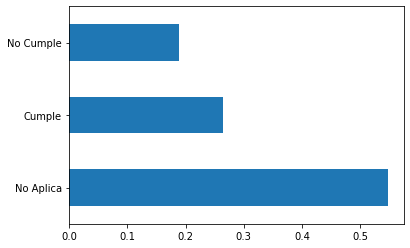

----------------------------------------------------------------------------------------------------------------
DEPARTAMENTO
 
SANTANDER          0.377269
BOGOTA             0.249180
BOLIVAR            0.094263
ANTIOQUIA          0.064154
META               0.046439
CUNDINAMARCA       0.030546
N. DE SANTANDER    0.029161
HUILA              0.015820
MAGDALENA          0.012758
VALLE DEL CAUCA    0.011664
ATLANTICO          0.009988
CASANARE           0.008821
CESAR              0.008165
CALDAS             0.007509
PUTUMAYO           0.006270
BOYACA             0.005759
TOLIMA             0.005759
SUCRE              0.004812
RISARALDA          0.003135
CORDOBA            0.002406
NARIÑO             0.001750
QUINDIO            0.001458
ARAUCA             0.000875
SAN ANDRES         0.000802
CAUCA              0.000656
CHOCO              0.000292
CAQUETA            0.000219
VICHADA            0.000073
Name: Departamento, dtype: float64


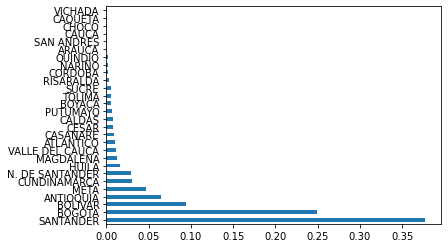

----------------------------------------------------------------------------------------------------------------
SIGLAS_DOC
 
CC     0.994897
TI     0.001895
NIT    0.001750
CE     0.001385
RC     0.000073
Name: Siglas_Doc, dtype: float64


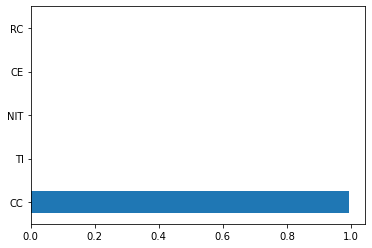

----------------------------------------------------------------------------------------------------------------
GRUPO_ROL_SOLUCION
 
Asesor de Servicio Contact Center          0.604068
Asesor de Servicio Front Ecopetrol         0.197055
Asesor solucionador Ecopetrol              0.165707
Asesor de Servicio Front Contact Center    0.033171
Name: Grupo_Rol_Solucion, dtype: float64


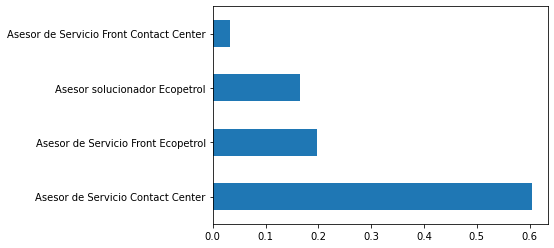

----------------------------------------------------------------------------------------------------------------
CANAL
 
Email BackOffice           0.451484
Telefónico                 0.435882
Oficina De Atención CAL    0.102136
Chat                       0.009040
Escrito Radicado           0.001458
Name: Canal, dtype: float64


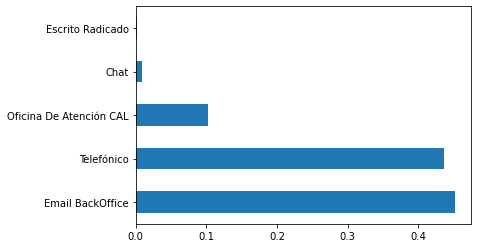

----------------------------------------------------------------------------------------------------------------
NIVEL_3
 
Legal / Reconocimiento Trabajadores (Incluye Bachiller ECP)                   0.305387
Legal / Reconocimiento Pensionados (Incluye Sustitutos)                       0.175986
Anticipo Trabajadores (Incluye BXC)                                           0.131734
Anticipo Pensionados (Incluye Sustitutos)                                     0.115550
Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)            0.088212
Soporte Plataforma para Instituciones Educativas vía TIB                      0.081723
Solicitud de educación inclusiva                                              0.030182
Inscripción solicitud becas Comité de Educación Convencional Activos          0.025734
Reintegro de dinero trabajadores Educación (Incluye Bachiller ECP)            0.021579
Inscripción casos especiales comité de educación convencional activos         0.007217
Reinteg

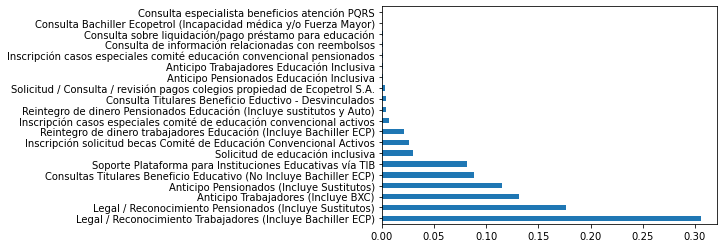

----------------------------------------------------------------------------------------------------------------
NIVEL_2
 
Beneficio Educativo - Regular               0.964059
Beneficio Educativo - Inclusiva             0.032660
Beneficio Educativo - Colegios Ecopetrol    0.003281
Name: Nivel_2, dtype: float64


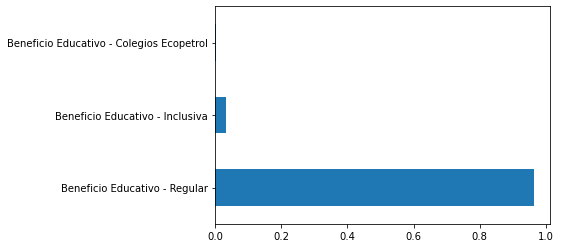

----------------------------------------------------------------------------------------------------------------
CUMPLE_OBJETIVO_ENNIVEL2
 
No Aplica    0.783699
Cumple       0.208063
No Cumple    0.008238
Name: Cumple_Objetivo_EnNivel2, dtype: float64


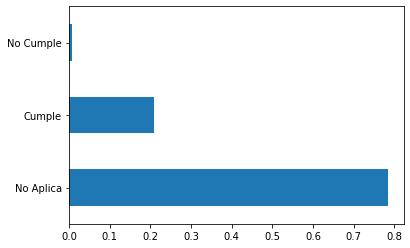

----------------------------------------------------------------------------------------------------------------
SISTEMA_PAGO
 
Transacciones        0.736969
No Aplica            0.210760
Puesto de Trabajo    0.052271
Name: Sistema_Pago, dtype: float64


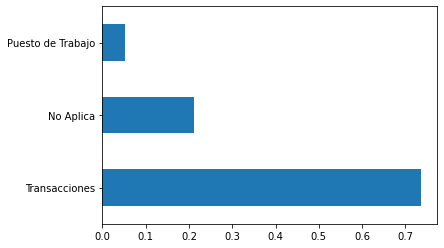

----------------------------------------------------------------------------------------------------------------
NOMBRE_GRUPOSOLUCION
 
Grupo Primer Nivel Personal                   0.783699
Equipo Plan Educacional                       0.126340
Profesional Transferencia de Información      0.049646
Anticipos – Equipo Plan Educacional           0.019538
Profesional Educación Inclusiva               0.018371
Profdecolegios propiedad de Ecopetrol S.A.    0.002041
Equipo Beneficio Educativo - Desvinculados    0.000365
Name: Nombre_GrupoSolucion, dtype: float64


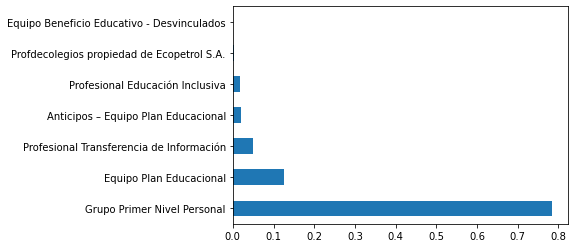

----------------------------------------------------------------------------------------------------------------
GRUPO_ROL_CREACION
 
Asesor de Servicio Contact Center          0.740905
Asesor de Servicio Front Ecopetrol         0.206824
Asesor de Servicio Front Contact Center    0.052271
Name: Grupo_Rol_Creacion, dtype: float64


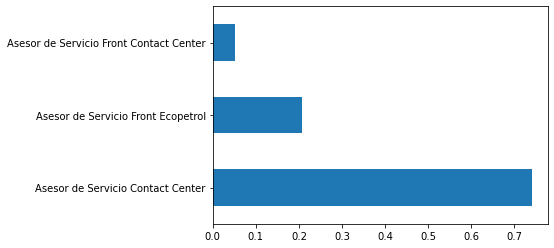

----------------------------------------------------------------------------------------------------------------
REGIONAL
 
CENTRO ORIENTE       0.691915
NORTE                0.123205
OCCIDENTE            0.099949
LLANOS ORIENTALES    0.047605
SUR                  0.022089
MAGDALENA MEDIO      0.015237
Name: Regional, dtype: float64


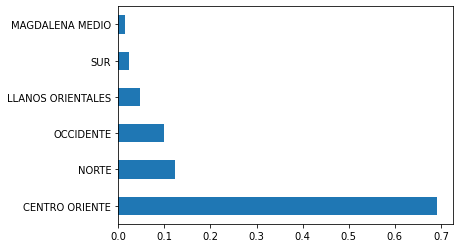

In [211]:
for i in list(data.columns):
    print('----------------------------------------------------------------------------------------------------------------')
    print(i.upper())
    print (' ')
    univariado(data,i )

### **Columnas con los textos a analizar**

In [212]:

df['# Palabras_ObservacionCreacion'] = df['Observacion_Creacion'].str.split().str.len()
df['# Palabras_ObservacionSolucion'] = df['Observacion_Solucion'].str.split().str.len()
df['# Palabras_ObservacionCierre'] = df['Observacion_Cierre'].str.split().str.len()


In [213]:
df_Obser = df[['# Palabras_ObservacionCreacion', '# Palabras_ObservacionSolucion','# Palabras_ObservacionCierre' ]]
describe_var = df_Obser.describe().round(1)
describe_var = describe_var.append(pd.Series(df_Obser.var(), name = 'Variance')) 
describe_var = describe_var.append(pd.Series(df_Obser.sum(), name = 'Sum')) 

#descripcion_observ = df_OF_relevante[['# Palabras_fgs_ObservacionCreacion', '# Palabras_fgs_ObservacionSolucion','# Palabras_fgs_ObservacionCierre' ]].describe()
describe_var.round(1)

,# Palabras_ObservacionCreacion,# Palabras_ObservacionSolucion,# Palabras_ObservacionCierre
count,13717.0,13717.0,13717.0
mean,33.8,50.8,40.9
std,43.6,69.4,68.3
min,1.0,1.0,2.0
25%,10.0,12.0,4.0
50%,18.0,26.0,15.0
75%,39.0,52.0,40.0
max,518.0,500.0,500.0
Variance,1903.8,4820.6,4663.6
Sum,463059.0,696629.0,560905.0


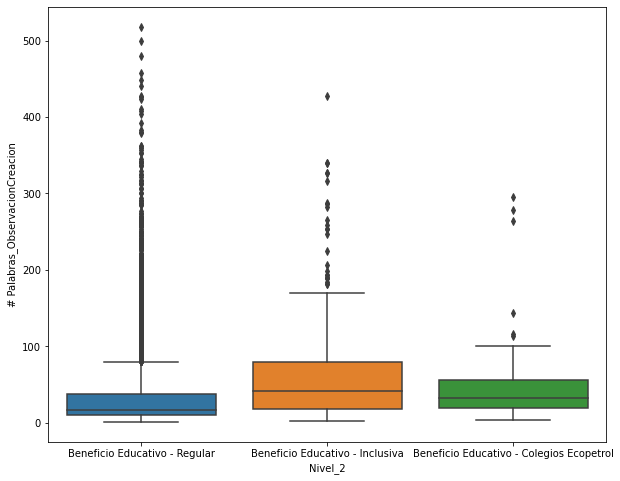

In [214]:
plt.figure(figsize = (10,8))
sns.boxplot(x = df['Nivel_2'], y =df['# Palabras_ObservacionCreacion'])

plt.show()

C:\Users\estduclui\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


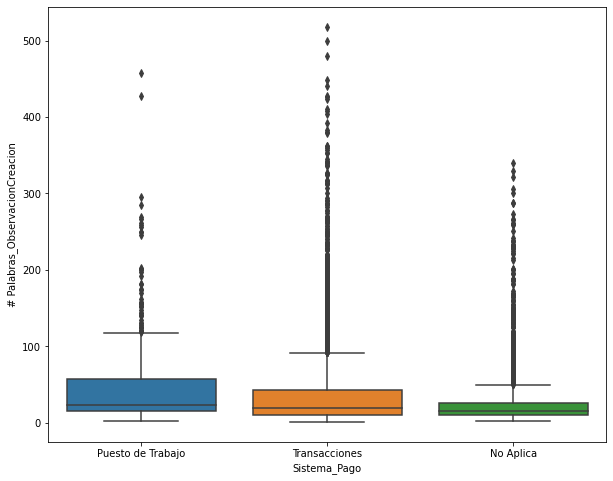

In [233]:
plt.figure(figsize = (10,8))
sns.boxplot(df['Sistema_Pago'], df['# Palabras_ObservacionCreacion'])
plt.show()

In [230]:
#plt.show?

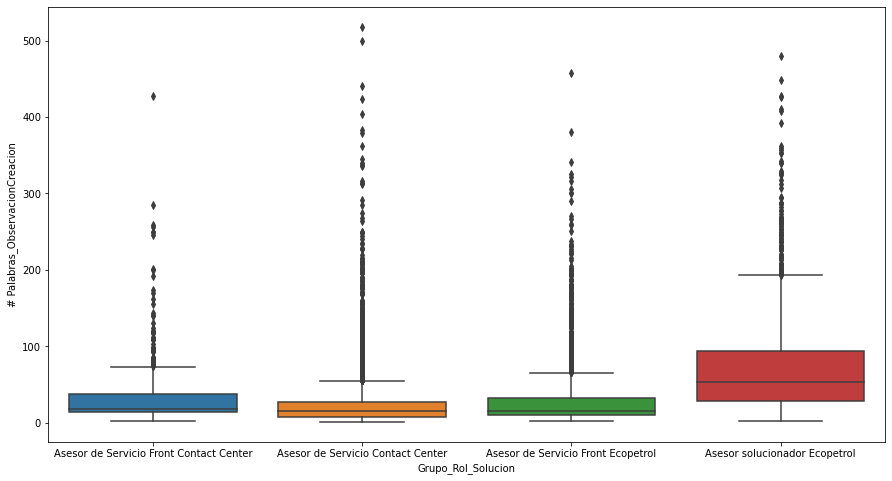

In [216]:
plt.figure(figsize = (15,8))
sns.boxplot(x = df['Grupo_Rol_Solucion'], y = df['# Palabras_ObservacionCreacion'])

plt.show()

**Porcentaje de palabras por nivel**

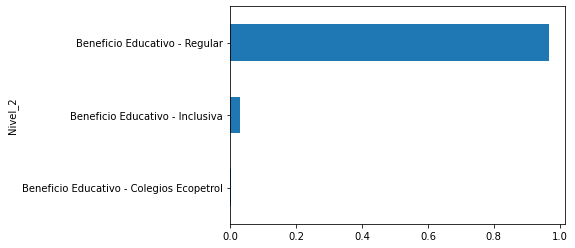

Nivel_2
Beneficio Educativo - Colegios Ecopetrol    0.003163
Beneficio Educativo - Inclusiva             0.030203
Beneficio Educativo - Regular               0.966634
Name: % total_palabras, dtype: float64


In [218]:
df['total_palabras']= df['# Palabras_ObservacionCreacion']+ df['# Palabras_ObservacionSolucion'] +df['# Palabras_ObservacionCierre']
df['% total_palabras'] = df['total_palabras']/df['total_palabras'].sum()
df.groupby('Nivel_2')['% total_palabras'].sum().plot.barh()
plt.show()
print(df.groupby('Nivel_2')['% total_palabras'].sum())

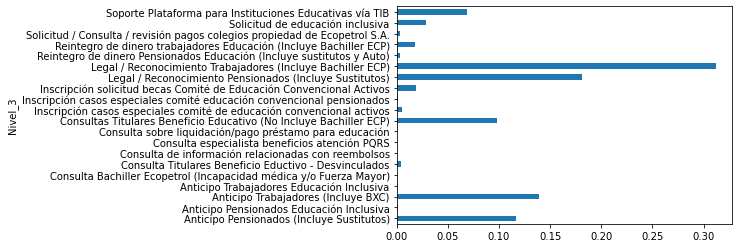

Nivel_3
Anticipo Pensionados (Incluye Sustitutos)                                     199846
Anticipo Pensionados Educación Inclusiva                                        2048
Anticipo Trabajadores (Incluye BXC)                                           238722
Anticipo Trabajadores Educación Inclusiva                                       1465
Consulta Bachiller Ecopetrol (Incapacidad médica y/o Fuerza Mayor)               458
Consulta Titulares Beneficio Eductivo - Desvinculados                           6379
Consulta de información relacionadas con reembolsos                             1292
Consulta especialista beneficios atención PQRS                                    24
Consulta sobre liquidación/pago préstamo para educación                          933
Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)            168435
Inscripción casos especiales comité de educación convencional activos           8504
Inscripción casos especiales comité educación convenciona

In [249]:
df.groupby('Nivel_3')['% total_palabras'].sum().plot.barh()
plt.show()
#print(df.groupby('Nivel_3')['% total_palabras'].sum())
print(df.groupby('Nivel_3')['total_palabras'].sum())

## **Análisis Multivariado**

### **Mapas de calor**


* Nivel 2 vs Canal vs Total de palabras

Canal                                           Chat  Email BackOffice  \
Nivel_2                                                                  
Beneficio Educativo - Colegios Ecopetrol    0.000000        128.459459   
Beneficio Educativo - Inclusiva             0.000000        130.609756   
Beneficio Educativo - Regular             221.508065        172.847975   

Canal                                     Escrito Radicado  \
Nivel_2                                                      
Beneficio Educativo - Colegios Ecopetrol          0.000000   
Beneficio Educativo - Inclusiva                 118.000000   
Beneficio Educativo - Regular                   195.210526   

Canal                                     Oficina De Atención CAL  Telefónico  
Nivel_2                                                                        
Beneficio Educativo - Colegios Ecopetrol                38.000000   93.000000  
Beneficio Educativo - Inclusiva                         65.625000   76.432432 

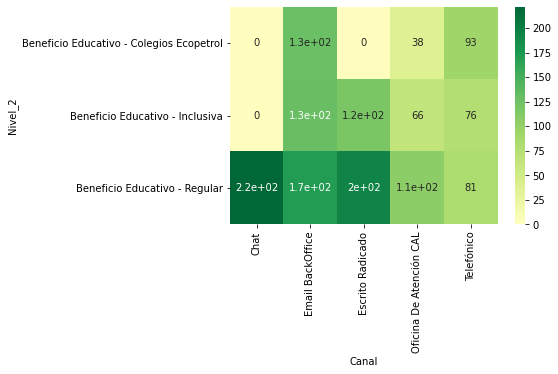

In [238]:
result = pd.pivot_table(data=df, index='Nivel_2', columns='Canal',values='total_palabras', fill_value =0)
print(result)

#create heat map of education vs marital vs response_rate
sns.heatmap(result, annot=True, cmap = 'RdYlGn', center=0.117)
plt.show()

* Nivel 2 vs Grupo_rol_solucion vs Total de palabras

Grupo_Rol_Solucion                        Asesor de Servicio Contact Center  \
Nivel_2                                                                       
Beneficio Educativo - Colegios Ecopetrol                          90.555556   
Beneficio Educativo - Inclusiva                                   94.556338   
Beneficio Educativo - Regular                                    104.314444   

Grupo_Rol_Solucion                        Asesor de Servicio Front Contact Center  \
Nivel_2                                                                             
Beneficio Educativo - Colegios Ecopetrol                                 0.000000   
Beneficio Educativo - Inclusiva                                        112.750000   
Beneficio Educativo - Regular                                          260.690745   

Grupo_Rol_Solucion                        Asesor de Servicio Front Ecopetrol  \
Nivel_2                                                                        
Beneficio Educativ

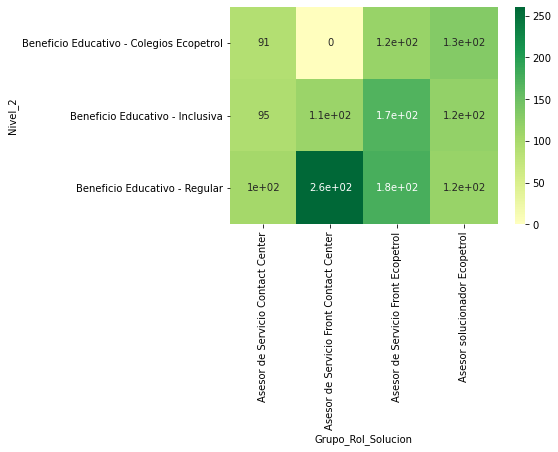

In [242]:
result = pd.pivot_table(data=df, index='Nivel_2', columns='Grupo_Rol_Solucion',values='total_palabras', fill_value =0)
print(result)

#create heat map of education vs marital vs response_rate
sns.heatmap(result, annot=True, cmap = 'RdYlGn', center=0.117)
plt.show()

* Nivel 3 vs Canal vs Total de palabras

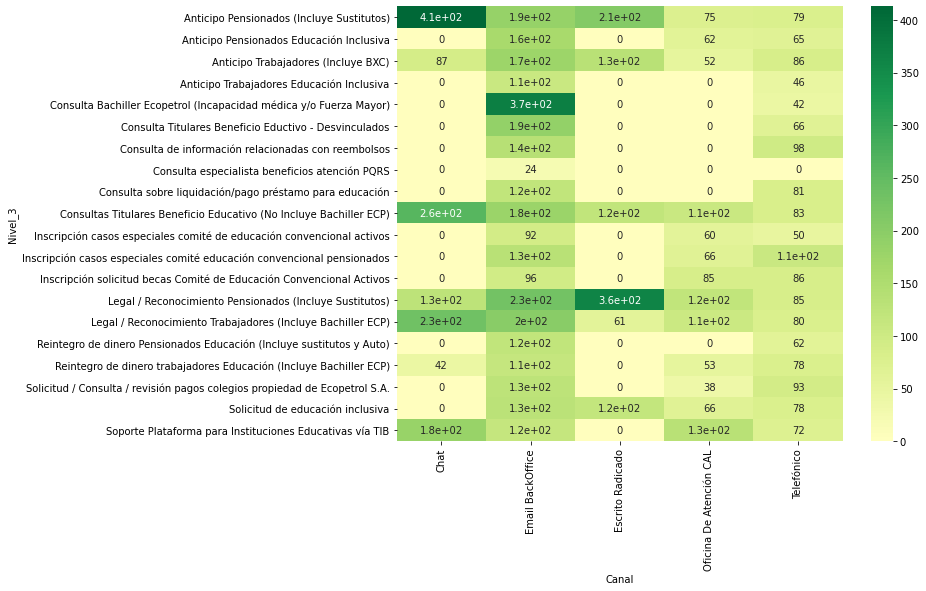

In [246]:
result = pd.pivot_table(data=df, index='Nivel_3', columns='Canal',values='total_palabras', fill_value =0)
#print(result)
plt.figure(figsize = (10,8))
#create heat map of education vs marital vs response_rate
sns.heatmap(result, annot=True, cmap = 'RdYlGn', center=0.117)
plt.show()

* Grupo_Rol_Solucion vs Canal vs Total de palabras

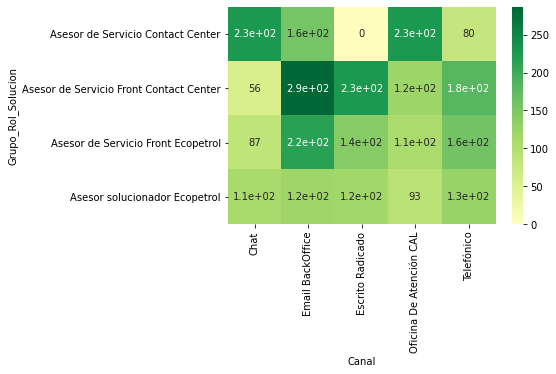

In [245]:
result = pd.pivot_table(data=df, index='Grupo_Rol_Solucion', columns='Canal',values='total_palabras', fill_value =0)
#print(result)

#create heat map of education vs marital vs response_rate
sns.heatmap(result, annot=True, cmap = 'RdYlGn', center=0.117)
plt.show()

### **Análisis de correspondencias multiples MCA**

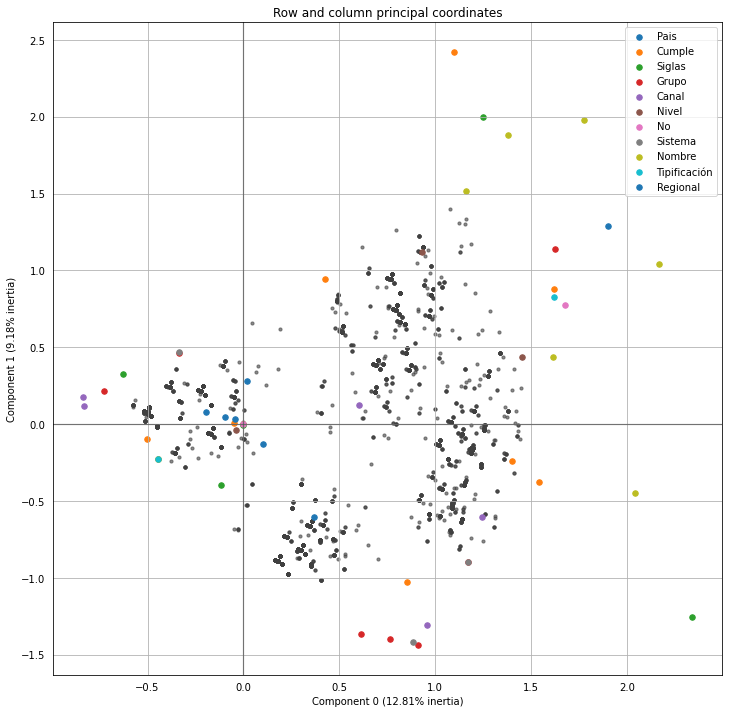

In [247]:
columnas = list(df_columnasCat[(df_columnasCat['#valores dintintos'] <= 10)].Nombre_columna)
X = df[columnas]
mca = prince.MCA()
mca = mca.fit(X)
mca1 = mca.transform(X) 
#print(mca1)
ax = mca.plot_coordinates(
     X=X,
     ax=None,
     figsize=(12, 12),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
     )